In [53]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import plotly.express as px
import pycountry

In [54]:
df = pd.read_csv('agrofood_co2_emission_cleaned.csv')
df = df.convert_dtypes()

print("columns:\n\n", df.columns, "\n\n")
print("description:\n\n", df.describe())


columns:

 Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'total_emission', 'Average Temperature °C',
       'Total Population', 'Temperature Category', 'Population Size'],
      dtype='object') 


description:

              Year  Savanna fires  Forest fires  Crop Residues  \
count      6965.0         6965.0        6965.0         6

In [ ]:
natural_sources = [
    "Savanna fires", "Forest fires", "Crop Residues", "Rice Cultivation",
    "Drained organic soils (CO2)", "Manure applied to Soils", "Manure left on Pasture",
    "Fires in organic soils", "Fires in humid tropical forests"
]

manmade_sources = [
    "Pesticides Manufacturing", "Food Transport", "Food Household Consumption",
    "Food Retail", "On-farm Electricity Use", "Food Packaging",
    "Agrifood Systems Waste Disposal", "Food Processing", "Fertilizers Manufacturing",
    "IPPU", "Manure Management", "On-farm energy use"
]

df_natural = df[["Year"] + natural_sources].set_index("Year")
df_manmade = df[["Year"] + manmade_sources].set_index("Year")

total_natural = df[natural_sources].sum()
total_manmade = df[manmade_sources].sum()

top5_natural = total_natural.sort_values(ascending=False).head(5).index.tolist()
top5_manmade = total_manmade.sort_values(ascending=False).head(5).index.tolist()

df_natural_top5_grouped = df.groupby('Year')[top5_natural].sum()
df_manmade_top5_grouped = df.groupby('Year')[top5_manmade].sum()

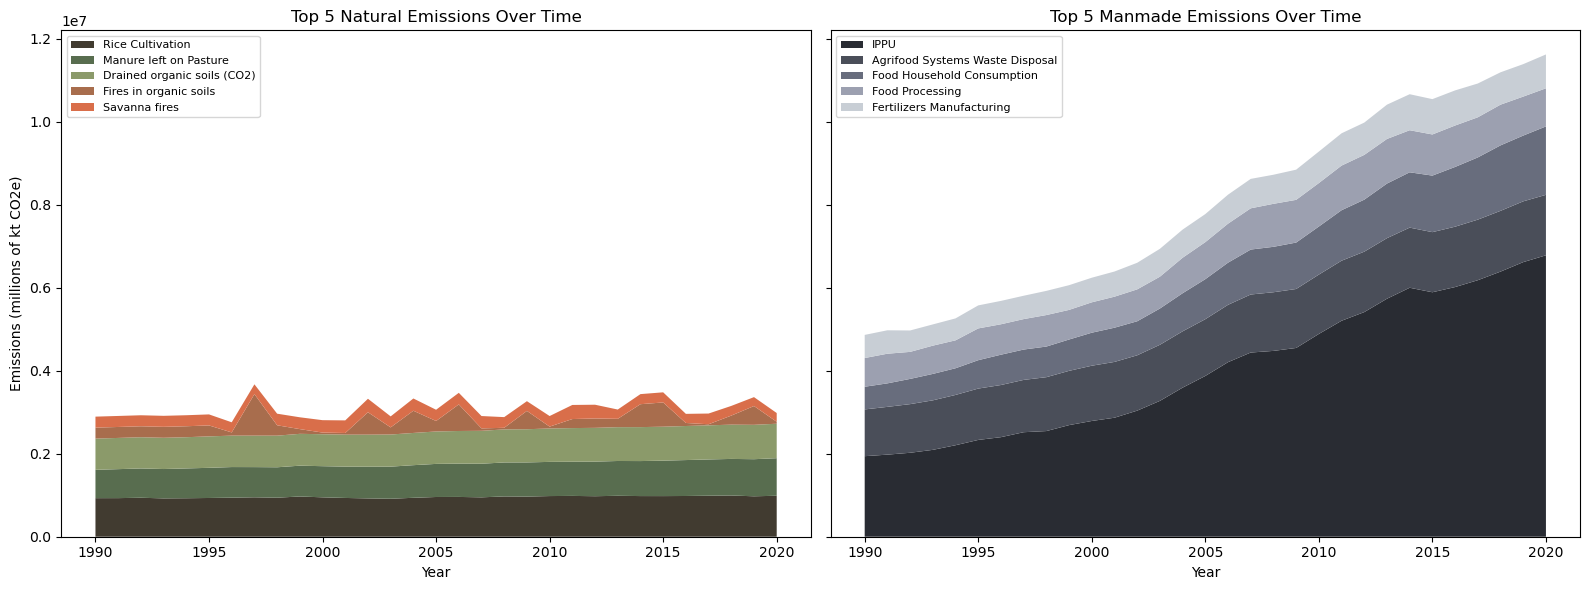

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].stackplot(
    df_natural_top5_grouped.index,
    *[df_natural_top5_grouped[col] for col in top5_natural],
    labels=top5_natural,
    colors=['#d96e4a', '#a86d4d', '#8b9a6a', '#586d4f', '#413b30'][::-1]
)
axes[0].set_title("Top 5 Natural Emissions Over Time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Emissions (millions of kt CO2e)")
axes[0].legend(loc='upper left', fontsize=8)

axes[1].stackplot(
    df_manmade_top5_grouped.index,
    *[df_manmade_top5_grouped[col] for col in top5_manmade],
    labels=top5_manmade,
    colors=['#292c33', '#4a4e59', '#686d7d', '#9ca0b0', '#c8ced5']
)
axes[1].set_title("Top 5 Manmade Emissions Over Time")
axes[1].set_xlabel("Year")
axes[1].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [57]:
def country_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

In [58]:
df_choropleth = df.groupby(['Area', 'Year'], as_index=False)['total_emission'].sum()
df_choropleth.rename(columns={'Area': 'Country'}, inplace=True)
df_choropleth['ISO3'] = df_choropleth['Country'].apply(country_to_iso3)
missing_iso = df_choropleth[df_choropleth['ISO3'].isnull()]['Country'].unique()
print("Missing ISO3 codes for:", missing_iso)

Missing ISO3 codes for: <StringArray>
[                'Belgium-Luxembourg',   'Bolivia (Plurinational State of)',
                    'Channel Islands',               'China, Hong Kong SAR',
                   'China, Macao SAR',          'China, Taiwan Province of',
                    'China, mainland',                     'Czechoslovakia',
   'Democratic Republic of the Congo',                       'Ethiopia PDR',
                           'Holy See',         'Iran (Islamic Republic of)',
   'Micronesia (Federated States of)',       'Netherlands (Kingdom of the)',
      'Netherlands Antilles (former)',    'Pacific Islands Trust Territory',
                          'Palestine',                  'Republic of Korea',
              'Serbia and Montenegro',                     'Sudan (former)',
                               'USSR',       'United States Virgin Islands',
 'Venezuela (Bolivarian Republic of)',          'Wallis and Futuna Islands',
                       'Yugoslav SFR']

In [60]:
manual_iso3_fixes = {
    'Belgium-Luxembourg': 'BEL',
    'Bolivia (Plurinational State of)': 'BOL',
    'Channel Islands': 'GBR',
    'China, Hong Kong SAR': 'HKG',
    'China, Macao SAR': 'MAC',
    'China, Taiwan Province of': 'TWN',
    'China, mainland': 'CHN',
    'Czechoslovakia': 'CZE', 
    'Democratic Republic of the Congo': 'COD',
    'Ethiopia PDR': 'ETH',
    'Holy See': 'VAT',
    'Iran (Islamic Republic of)': 'IRN',
    'Micronesia (Federated States of)': 'FSM',
    'Netherlands (Kingdom of the)': 'NLD',
    'Netherlands Antilles (former)': 'ANT',
    'Pacific Islands Trust Territory': 'PCN',
    'Palestine': 'PSE',
    'Republic of Korea': 'KOR',
    'Serbia and Montenegro': 'SRB',
    'Sudan (former)': 'SDN',
    'USSR': 'RUS',
    'United States Virgin Islands': 'VIR',
    'Venezuela (Bolivarian Republic of)': 'VEN',
    'Wallis and Futuna Islands': 'WLF',
    'Yugoslav SFR': 'YUG'
}

df_choropleth['ISO3'] = df_choropleth['Country'].apply(country_to_iso3)

df_choropleth['ISO3'] = df_choropleth.apply(
    lambda row: manual_iso3_fixes.get(row['Country'], row['ISO3']),
    axis=1
)

still_missing = df_choropleth[df_choropleth['ISO3'].isnull()]['Country'].unique()
print("Still missing ISO3 codes:", still_missing)



Still missing ISO3 codes: <StringArray>
[]
Length: 0, dtype: string
